In [1]:
import shap
import pandas as pd
import scipy as sp
import numpy as np
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from treeinterpreter.feature_importance import feature_importance as FI
from treeinterpreter.feature_importance import MDA

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Compare different methods in terms of feature pruning performance

### load data

In [2]:
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
         'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'label']
df_train = pd.read_csv('../data/adult/adult.data', header=None, names=names, index_col=False)
print(df_train.shape)
df_train.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
df_test = pd.read_csv('../data/adult/adult.test', index_col=False, header=None, skiprows=1, names=names)
df_test.head()
print(df_test.shape)

(16281, 15)


### Preprocessing

In [4]:
df_train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


- replace ' ?' to null 

In [5]:
df_train = df_train.replace(' ?', np.NaN)
df_test = df_test.replace(' ?', np.NaN)

- Drop noncomplete rows

In [6]:
df_train = df_train.dropna()
df_test = df_test.dropna()
print(df_train.shape, df_test.shape)

(30162, 15) (15060, 15)


- Make the label of test set and train set the same

In [7]:
df_test['label'].unique(), df_train['label'].unique()

(array([' <=50K.', ' >50K.'], dtype=object),
 array([' <=50K', ' >50K'], dtype=object))

In [8]:
df_test['label'] = [x[:-1] for x in df_test['label']]

In [9]:
df_test['label'].unique(), df_train['label'].unique()

(array([' <=50K', ' >50K'], dtype=object),
 array([' <=50K', ' >50K'], dtype=object))

- Drop education because it duplicates education_num. Because of that, in Gini importance, it is not zero, in MDI, it is zero.

In [10]:
from collections import defaultdict
d = defaultdict(LabelEncoder)

# Encoding the variable
df_train_encoded = df_train.apply(lambda x: d[x.name].fit_transform(x) if x.dtype != int else x)

# Using the dictionary to label future data
df_test_encoded = df_test.apply(lambda x: d[x.name].transform(x) if x.dtype != int else x)

stacked = df_train_encoded.copy()
stacked = stacked.append(df_test_encoded)
stacked = stacked.drop('education', axis=1)
names = list(stacked.columns)

In [11]:
tmp = stacked
feature_names = list(tmp.columns)[:-1]
df_train_one_hot = tmp.iloc[:df_train.shape[0], :]
df_test_one_hot = tmp.iloc[df_train.shape[0]:, :]
X_train = np.array(df_train_one_hot.iloc[:, :-1])
y_train = np.array(df_train_one_hot.iloc[:, -1])
X_test = np.array(df_test_one_hot.iloc[:, :-1])
y_test = np.array(df_test_one_hot.iloc[:, -1])

- save the intermediate results

In [12]:
np.savetxt('../intermediate/01_adult/X_train.csv', X_train, delimiter=',', fmt='%d')
np.savetxt('../intermediate/01_adult/y_train.csv', y_train, delimiter=',', fmt='%d')
np.savetxt('../intermediate/01_adult/X_test.csv', X_test, delimiter=',', fmt='%d')
np.savetxt('../intermediate/01_adult/y_test.csv', y_test, delimiter=',', fmt='%d')

### Train RF

In [13]:
rf = rfc(n_estimators=100, max_depth=20)
rf.fit(X_train, y_train)
gini_imp = rf.feature_importances_

- accuracy

In [14]:
print('accuracy of RF is {0:.3f}'.format(accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))))

accuracy of RF is 0.858


- Plot feature importance

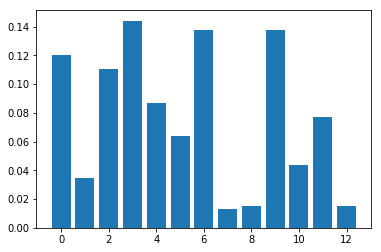

In [15]:
plt.bar(x = np.arange(X_train.shape[1]), height = gini_imp)
plt.show()

### prune features based on their importance measures

- classic gini importance

In [21]:
def aggregate_feature_importance(importances, names, feature_names):
    agg_feature_imp = np.zeros((len(names), ))
    for j, long_name in enumerate(feature_names):
        for i, name in enumerate(names):
            if name in long_name:
                agg_feature_imp[i] += importances[j]
    return agg_feature_imp

In [20]:
def distribute_rank(ranks, names, feature_names):
    out = np.zeros((len(feature_names),))
    for j, long_name in enumerate(feature_names):
        for i, name in enumerate(names):
            if name in long_name:
                out[j] = ranks[i]
    return out

     - plot the gini importance

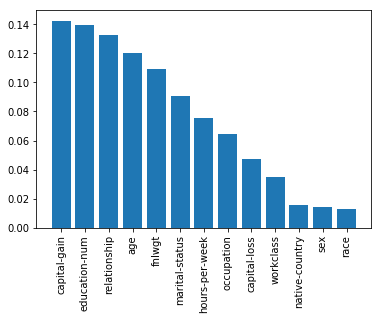

In [18]:
gini_agg_imp = aggregate_feature_importance(gini_imp, names[:-1], feature_names)
ix = np.argsort(gini_agg_imp * -1)
plt.bar(x = list(range(13)), height = gini_agg_imp[ix])
plt.xticks(list(range(13)), np.array(names[:-1])[ix], rotation='vertical')
plt.show()

- debiased gini importance

In [20]:
y_train_one_hot = OneHotEncoder().fit_transform(np.array(df_train_encoded.iloc[:, -1:])).todense()

In [21]:
debiased_fi_mean, debiased_fi_std = FI(rf, X_train, y_train_one_hot, type='oob', normalized=False)

    - plot debiased gini importance

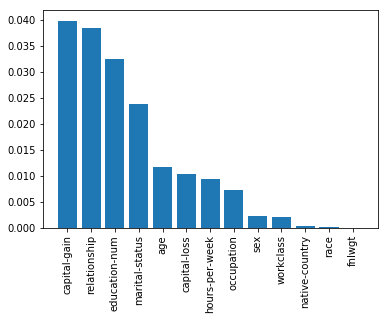

In [22]:
debiased_agg_imp = aggregate_feature_importance(debiased_fi_mean, names[:-1], feature_names)
ix = np.argsort(debiased_agg_imp * -1)
plt.bar(x = list(range(13)), height = debiased_agg_imp[ix])
plt.xticks(list(range(13)), np.array(names[:-1])[ix], rotation='vertical')
plt.show()

- OOB MDA

In [15]:
MDA_oob_imp, MDA_oob_std = MDA(rf, X_train, y_train[:, np.newaxis], type='oob', n_trials=4)

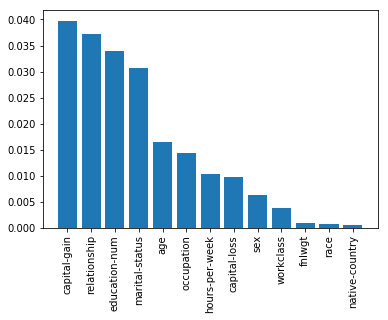

In [19]:
ix = np.argsort(MDA_oob_imp * -1)
plt.bar(x = list(range(13)), height = MDA_oob_imp[ix])
plt.xticks(list(range(13)), np.array(names[:-1])[ix], rotation='vertical')
plt.show()

- MDA

In [22]:
MDA_imp, MDA_std = MDA(rf, X_test, y_test[:, np.newaxis], type='test', n_trials=4)

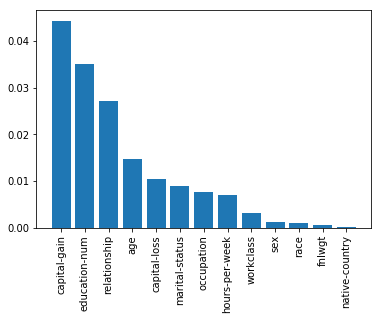

In [26]:
ix = np.argsort(MDA_imp * -1)
plt.bar(x = list(range(13)), height = MDA_imp[ix])
plt.xticks(list(range(13)), np.array(names[:-1])[ix], rotation='vertical')
plt.show()

- tree SHAP

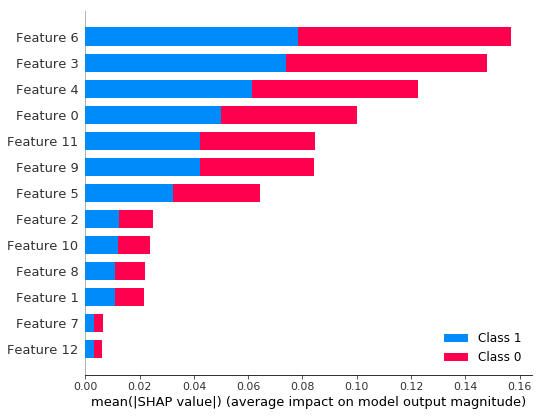

In [51]:
explainer = shap.TreeExplainer(rf)
samples = np.random.choice(range(X_train.shape[0]), 100)
shap_values = explainer.shap_values(X_train[samples, :])
shap.summary_plot(shap_values, X_train[samples, :], plot_type="bar")

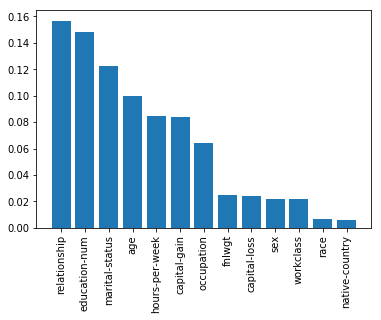

In [52]:
shap_imp = np.mean(abs(shap_values[0]), 0) + np.mean(abs(shap_values[1]), 0)
shap_agg_imp = aggregate_feature_importance(shap_imp, names[:-1], feature_names)
ix = np.argsort(shap_agg_imp * -1)
plt.bar(x = list(range(13)), height = shap_agg_imp[ix])
plt.xticks(list(range(13)), np.array(names[:-1])[ix], rotation='vertical')
plt.show()

### Comparison

In [61]:
ix = np.argsort(MDA_agg_imp * -1)
sp.stats.rankdata(MDA_agg_imp[ix])

array([13. , 12. , 11. , 10. ,  9. ,  8. ,  7. ,  6. ,  5. ,  4. ,  2.5,
        2.5,  1. ])

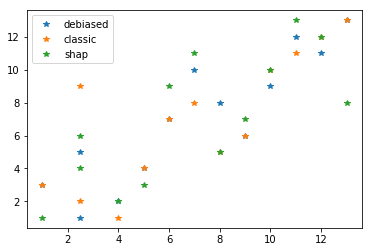

In [62]:
plt.plot(sp.stats.rankdata(MDA_agg_imp[ix]), sp.stats.rankdata(debiased_agg_imp[ix]), '*')
plt.plot(sp.stats.rankdata(MDA_agg_imp[ix]), sp.stats.rankdata(gini_agg_imp[ix]), '*')
plt.plot(sp.stats.rankdata(MDA_agg_imp[ix]), sp.stats.rankdata(shap_agg_imp[ix]), '*')
plt.legend(['debiased', 'classic', 'shap'])
plt.show()

In [63]:
sp.corrcoef(sp.stats.rankdata(MDA_agg_imp[ix]), sp.stats.rankdata(gini_agg_imp[ix]))

array([[1.        , 0.78954683],
       [0.78954683, 1.        ]])

In [64]:
sp.corrcoef(sp.stats.rankdata(MDA_agg_imp[ix]), sp.stats.rankdata(debiased_agg_imp[ix]))

array([[1.        , 0.89133509],
       [0.89133509, 1.        ]])

In [65]:
sp.corrcoef(sp.stats.rankdata(MDA_agg_imp[ix]), sp.stats.rankdata(shap_agg_imp[ix]))

array([[1.        , 0.75378338],
       [0.75378338, 1.        ]])